# SOFIMA alignment of FAST-EM data
Author: Arent Kievits  
Date: 26-06-2024

This notebook serves as an example to use [SOFIMA](https://github.com/google-research/sofima?tab=readme-ov-file) to elastically align a subset of FAST-EM data in WebKnossos. 
The notebook can be modified to analyze different datasets.  
The software assumes the use of a GPU with CUDA, but can also run on CPU

In [2]:
import webknossos as wk
import numpy as np
from fastem_sofima.importo import import_wk_dataset_remote
import math
from tqdm.notebook import tqdm
import os

# set the environment variable 'CUDA_VISIBLE_DEVICES'
# this sets which GPU can be seen by the program
# Either set it to "0", "1", "2", "3"
# or if you want to use multiple GPUs add commas between the numbers
# e.g. "0,1"
# the numbers correspond with those in the command 'nvidia-smi'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
# WebKnossos settings
url = "https://webknossos.tnw.tudelft.nl" # Local WebKnossos instance host address or "webknossos.org"
dataset_name = "20231107_MCF7_UAC_test" # Dataset name as in WebKnossos
organization_id = "hoogenboom-group" # Organization ID
layer="postcorrection_rigid_scaled" # Layer name 2 align in WebKnossos
dataset_full_url = "https://webknossos.tnw.tudelft.nl/links/G98PjX5Cm8F5a8_3" # Link to data

## 1. Define bounding box from data
The alignment is only performed on the overlapping dataset, that means parts of sections that are not continuous throughout the volume are cropped. We apply a series of image processing operations to define the data bounding box for SOFIMA on the continuous part only

In [ ]:
# Import dataset
dataset, voxel_size = import_wk_dataset_remote(
    dataset_full_url=dataset_full_url
    )

# Get lowest mag
EM = dataset.get_layer(layer) # EM data Layer
MAG_low = list(EM.mags.keys())[-1]

mag_view = EM.get_mag(MAG_low) # MagView
# Get data at required resolution
# Read data from remote
data_bbox = mag_view.read()

In [5]:
data_bbox.shape

(1, 288, 264, 3)

In [6]:
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, try_all_threshold
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches
from scipy.ndimage import gaussian_filter, binary_dilation

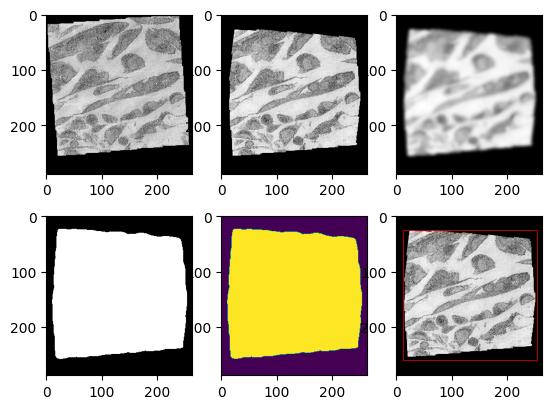

In [ ]:
# Plot first z level and calculate min projection to find continuous data in z
# Threshold, dilate, label image to find bbox
data_min_proj = np.min(data_bbox, axis=3)
blurred = gaussian_filter(data_min_proj[0, :, :], sigma=3)
thres = threshold_otsu(blurred)
object = blurred > thres
object = binary_dilation(object, np.ones((7, 7)))
labeled_image = label(object)
props = regionprops(labeled_image)
minr, minc, maxr, maxc = props[0].bbox

fig, ax = plt.subplots(2, 3)
ax[0][0].imshow(data_bbox[0, :, :, 0], cmap=plt.cm.Greys_r)
ax[0][1].imshow(data_min_proj[0, :, :], cmap=plt.cm.Greys_r)
ax[0][2].imshow(blurred, cmap=plt.cm.Greys_r)
ax[1][0].imshow(object, cmap=plt.cm.Greys_r)
ax[1][1].imshow(labeled_image)
ax[1][2].imshow(data_min_proj[0, :, :], cmap=plt.cm.Greys_r)

ax[0][0].set_title("z=0")
ax[0][1].set_title("minimum projection")
ax[0][2].set_title("blurred")
ax[1][0].set_title("thresholded")
ax[1][1].set_title("labeled")
ax[1][2].set_title("bounding box")
rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=0.5)
ax[1][2].add_patch(rect)

In [8]:
props[0].bbox

(25, 11, 259, 255)

In [9]:
# Define WebKnossos bounding box at full resolution
# Mag(128)
bbox_cropped = wk.BoundingBox((minc, minr, 0),
                              (maxc - minc, maxr - minr, data_bbox.shape[-1])) # ((x0, y0, z0), (x_size, y_size, z_size))
bbox_cropped = bbox_cropped.from_mag_to_mag1(from_mag=MAG_low)
bbox_cropped

BoundingBox(topleft=(1408, 3200, 0), size=(31232, 29952, 3))

# 2. Load data
With the bounding box for SOFIMA defined, we can load in the data from the bounding box

In [10]:
dataset, voxel_size = import_wk_dataset_remote(
    dataset_full_url=dataset_full_url
    )
himag = wk.Mag("1-1-1") # Highest magnification
bbox_at_mag = bbox_cropped.align_with_mag(himag)

# Get EM layer
EM = dataset.get_layer(layer)
mag_view = EM.get_mag(himag) # MagView
view = mag_view.get_view(absolute_offset=bbox_at_mag.topleft, size=bbox_at_mag.size) # "absolute_offset" and "size" are in Mag(1)!
bbox_size = 5000

In [11]:
x0 = view.bounding_box.in_mag(himag).topleft.x
y0 = view.bounding_box.in_mag(himag).topleft.y

### 2.1 Define bboxes (chunks) for parallel import
Remote import of large datasets can be slow and loading times may hit the timeout limit. Import data in chunks

In [12]:
# Infer data set dimensions (in desired mag)
dim = view.bounding_box.in_mag(himag).size

# Determine number of chunks to split data into in all dimensions
chunks_x, chunks_y, chunks_z = math.ceil(dim.x / bbox_size), math.ceil(dim.y / bbox_size), math.ceil(dim.z / 256)

# Determine z size of bbox (x an y sizes are defined by bbox_size)
size_z = min(dim.z, 256)

# From # chunks, define bboxes to be used
# Loop over x, y, z chunk indices, define bbox on multiples of bbox_size starting from topleft of og bbox
bboxes = []
for i in range(chunks_x):
    for j in range(chunks_y):
        if bbox_size*(i+1) >= dim.x: # check if bbox is larger than max x and adjust bbox dimension 
            bbox_size_x = dim.x - bbox_size*i
        else: # not exceeding stack dimensions, use regular bbox_size
            bbox_size_x = bbox_size
        
        if bbox_size*(j+1) >= dim.y: # check if bbox is larger than max y and adjust bbox dimension 
            bbox_size_y = dim.y - bbox_size*j
        else: # not exceeding stack dimensions, use regular bbox_size
            bbox_size_y =  bbox_size
        
        for k in range(chunks_z):
            # Generate bbox
            bbox = wk.BoundingBox(topleft=(x0 + bbox_size*i, y0 + bbox_size*j, 256*k),
                                  size=(bbox_size_x, bbox_size_y, size_z))\
                                    .from_mag_to_mag1(from_mag=himag)        
            bboxes.append(bbox)               

In [13]:
bboxes

[BoundingBox(topleft=(1408, 3200, 0), size=(5000, 5000, 3)),
 BoundingBox(topleft=(1408, 8200, 0), size=(5000, 5000, 3)),
 BoundingBox(topleft=(1408, 13200, 0), size=(5000, 5000, 3)),
 BoundingBox(topleft=(1408, 18200, 0), size=(5000, 5000, 3)),
 BoundingBox(topleft=(1408, 23200, 0), size=(5000, 5000, 3)),
 BoundingBox(topleft=(1408, 28200, 0), size=(5000, 4952, 3)),
 BoundingBox(topleft=(6408, 3200, 0), size=(5000, 5000, 3)),
 BoundingBox(topleft=(6408, 8200, 0), size=(5000, 5000, 3)),
 BoundingBox(topleft=(6408, 13200, 0), size=(5000, 5000, 3)),
 BoundingBox(topleft=(6408, 18200, 0), size=(5000, 5000, 3)),
 BoundingBox(topleft=(6408, 23200, 0), size=(5000, 5000, 3)),
 BoundingBox(topleft=(6408, 28200, 0), size=(5000, 4952, 3)),
 BoundingBox(topleft=(11408, 3200, 0), size=(5000, 5000, 3)),
 BoundingBox(topleft=(11408, 8200, 0), size=(5000, 5000, 3)),
 BoundingBox(topleft=(11408, 13200, 0), size=(5000, 5000, 3)),
 BoundingBox(topleft=(11408, 18200, 0), size=(5000, 5000, 3)),
 BoundingB

### 2.2 Read the data into a single `numpy` array

In [14]:
# Allocate memory
data_2_warp = np.zeros((1, dim.x, dim.y, dim.z), dtype=np.uint8)

# Read data from remote in chunks
# By looping through bboxes
x_offset = bboxes[0].topleft[0]
y_offset = bboxes[0].topleft[1]
for bbox_small in tqdm(bboxes,
                       desc="Reading data from bboxes",
                       total=len(bboxes),
                       unit="bbox"):
    # Fill slice in array with data from smaller bbox
    view_small = mag_view.get_view(absolute_offset=bbox_small.topleft, 
                                   size=bbox_small.size)
    x_start = bbox_small.topleft.x - x_offset
    x_end = x_start + bbox_small.size.x
    y_start = bbox_small.topleft.y - y_offset
    y_end = y_start + bbox_small.size.y
    
    data_2_warp[:, 
                x_start:x_end,
                y_start:y_end,
                :] = view_small.read()
# Transpose 
data_2_warp = np.transpose(data_2_warp, (1, 2, 3, 0))

Reading data from bboxes:   0%|          | 0/42 [00:00<?, ?bbox/s]

### 2.3 Read the data for the flow field computations
The data at reduced zoom levels is downsampled and much smaller, loading can be done in one chunk

In [15]:
## Mags to use for SOFIMA 
# We have found that a combination of 4-4-1 (16 nm/px), 8-8-1 (32 nm/px) and 16-16-1 (64 nm/px) works best for FAST-EM data
# Increasing the data resolution to 2-2-1 or 1-1-1 does not lead to better performance.
# Decreasing the data resolution to 32-32-1 or larger does not add any information
MAG = [wk.Mag("4-4-1"), wk.Mag("8-8-1"), wk.Mag("16-16-1")] 

data_zooms = {}
EM = dataset.get_layer(layer) # EM data Layer
# Iterate through zoom levels (a.k.a. MAGs)
for mag in MAG:
    mag_view = EM.get_mag(mag) # MagView
    bbox_at_mag = bbox_cropped.align_with_mag(mag)
    # Get data at required resolution
    view = mag_view.get_view(absolute_offset=bbox_at_mag.topleft, size=bbox_at_mag.size) # "absolute_offset" and "size" are in Mag(1)!
    # Read data from remote
    data = view.read()
    data_zooms[f"unaligned_{mag.x}x"] = np.transpose(data, (1, 2, 3, 0))

In [16]:
data_zooms["unaligned_4x"].shape

(7808, 7488, 3, 1)

# 3. Flow field estimation

First, we calculate the flow fields between the current section and the directly preceding section. Flow fields can also be computed between pairs of sections that are not directly adjacent. This is useful if sections are incomplete or missing, but is not something we have to worry about in this example.

In a distributed environment, this step would be done with the `EstimateFlow` processor.


In [17]:
from concurrent import futures
import time

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from connectomics.common import bounding_box
from sofima import flow_field
from sofima import flow_utils
from sofima import map_utils
from sofima import mesh
from sofima import warp
from tqdm.notebook import tqdm

In [18]:
# Ensure that we're running this code on a GPU machine. If this fails and you're using
# Google Colab, use "Edit >> Notebook settings" and set s"Hardware accelerator" to "GPU".
assert jax.devices()[0].platform == 'gpu'

In [19]:
# Both of the settings below are expressed in pixels.
patch_size = 160 # XY spatial context used for flow field estimation
stride = 40  # XY distance between centers of adjacent patches.

def _compute_flow(volume):
  mfc = flow_field.JAXMaskedXCorrWithStatsCalculator()
  flows = []
  prev = volume[..., 0, 0].T

  fs = []
  with futures.ThreadPoolExecutor() as tpe:
    # Prefetch the next sections to memory so that we don't have to wait for them
    # to load when the GPU becomes available.
    for z in range(1, volume.shape[2]):
      fs.append(tpe.submit(lambda z=z: volume[..., z, 0].T))

    for z in tqdm(range(0, volume.shape[2]-1)):
      curr = fs[z].result()

      # The batch size is a parameter which impacts the efficiency of the computation (but
      # not its result). It has to be large enough for the computation to fully utilize the
      # available GPU capacity, but small enough so that the batch fits in GPU RAM.
      flows.append(mfc.flow_field(prev, curr, (patch_size, patch_size),
                                  (stride, stride), batch_size=256))
      prev = curr

  return flows

Compute flows at 4x reduced in-plane resolution and downsampled versions. The lower resolution flow has reduced precision, but is helpful for providing approximate flow vectors in places where the full-resolution flow might be impossible to estimate, e.g. in the interior of cell bodies or blood vessels.


In [20]:
# Iterate through data zoom levels at compute flows
flows = {}
for zoom, mag in zip(data_zooms, MAG):
    flow_at_zoom = np.array(
        _compute_flow(data_zooms[zoom])
        )
    # Convert to [channels, z, y, x].
    flow_at_zoom = np.transpose(flow_at_zoom, [1, 0, 2, 3])
    # Pad to account for the edges of the images where there is insufficient context to estimate flow.
    pad = patch_size // 2 // stride
    flow_at_zoom = np.pad(flow_at_zoom, [[0, 0], [0, 0], [pad, pad], [pad, pad]], constant_values=np.nan)
    flows[f"flows{mag.x}x"] = flow_at_zoom

  0%|          | 0/2 [00:00<?, ?it/s]

2024-06-26 16:41:15.585665: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

The flow fields generated in the previous step are 4-channel arrays, where the first two channels store the XY components of the flow vector, and the two remaining channels are measures of estimation quality (see `sofima.flow_field._batched_peaks` for more info).

We now remove uncertain flow estimates by replacing them with NaNs, and merge the two flow arrays into a single flow field at full resolution. In a distributed environment, this step would be done with the `ReconcileAndFilterFlows` processor.

In [21]:
flows_clean = {}
# Iterate through flows and clean them
for flow in flows:
    flow_clean = flow_utils.clean_flow(flows[flow], 
                                       min_peak_ratio=1.2, 
                                       min_peak_sharpness=1.2, 
                                       max_magnitude=40, 
                                       max_deviation=10)
    flows_clean[f"{flow}_clean"] = flow_clean

Plot the horizontal component of the flow vector, before (left) and after (right) filtering. While blobs indicate areas where uncertain flow estimates were removed.

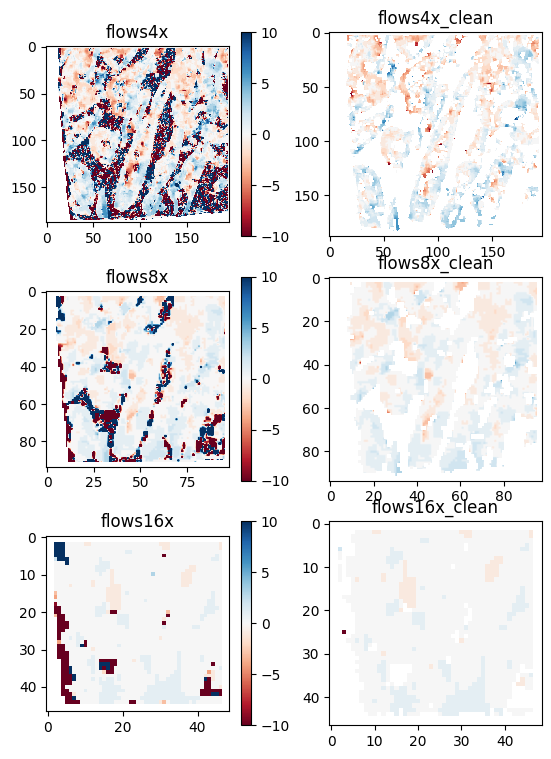

In [24]:
nrows = len(flows_clean.keys())
f, axes = plt.subplots(nrows, 2, figsize=(6.5, 3*nrows))
vmin, vmax = -10, 10
for ax, flow, flow_clean in zip(axes, flows, flows_clean):
    cax1 = ax[0].imshow(flows[flow][0, 1, ...], cmap=plt.cm.RdBu, vmin=vmin, vmax=vmax)
    ax[0].set_title(flow)
    ax[1].imshow(flows_clean[flow_clean][0, 1, ...], cmap=plt.cm.RdBu, vmin=vmin, vmax=vmax)
    ax[1].set_title(flow_clean)
    cbar1 = f.colorbar(cax1)

Interpolate lower resolution flows

In [25]:
from scipy import interpolate

In [26]:
scale = 0.5
clean_flows = [key for key in flows_clean.keys()]
highest_flow = clean_flows[0]
combine_flows = (flows_clean[highest_flow],)

for f in clean_flows[1:]:
  f_upsampled = np.zeros_like(flows_clean[highest_flow])
  oy, ox = np.ogrid[:flows_clean[f].shape[-2], :flows_clean[f].shape[-1]]
  oy = oy.ravel() / scale
  ox = ox.ravel() / scale
  
  box_high = bounding_box.BoundingBox(start=(0, 0, 0), size=(flows_clean[highest_flow].shape[-1], flows_clean[highest_flow].shape[-2], 1))
  box_f = bounding_box.BoundingBox(start=(0, 0, 0), size=(flows_clean[f].shape[-1], flows_clean[f].shape[-2], 1))

  for z in tqdm(range(flows_clean[f].shape[1])): # loop through z
    # Upsample and scale spatial components.
    resampled = map_utils.resample_map(
        flows_clean[f][:, z:z + 1, ...],  #
        box_f, box_high, 1 / scale, 1)
    f_upsampled[:, z:z + 1, ...] = resampled / scale
  combine_flows += (f_upsampled,)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
final_flow = flow_utils.reconcile_flows(combine_flows, max_gradient=0, max_deviation=20, min_patch_size=400)

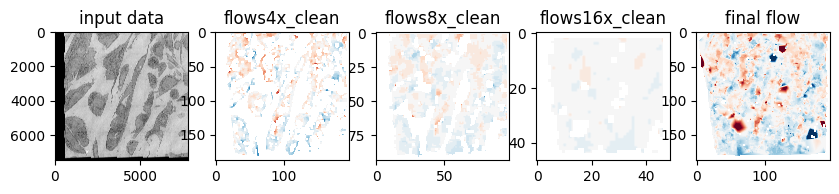

In [28]:
z_i = 1 # z index to plot

# Plot (left to right): high res. flow, upsampled low res. flow, combined flow to use for alignment.
f, ax = plt.subplots(1, len(combine_flows)+2, figsize=(10, 2.5))
data_full = list(data_zooms.items())[0][1]
ax[0].imshow(data_full[:, :, z_i, 0].T, cmap=plt.cm.Greys_r)
ax[0].set_title("input data")
ax[-1].imshow(final_flow[0, z_i, ...], cmap=plt.cm.RdBu, vmin=-10, vmax=10)
ax[-1].set_title("final flow")
for i, flow in enumerate(flows_clean):
    ax[i+1].imshow(flows_clean[flow][0, z_i, ...], cmap=plt.cm.RdBu, vmin=-10, vmax=10)
    ax[i+1].set_title(flow)

# 4. Mesh optimization

We use an elastic mesh optimizer to find a configuration of the imagery that is compatible with the estimated flow field and preserves the original geometry as much as possible.

The optimization proceeds sequentially, section by section. In a distributed environment, this computation can be parallelized across the plane (by independently solving overlapping XY tiles), as well as split into blocks along the Z axis. This makes it possible to scale this process to arbitrarily large volumes. For simplicity, here we solve the complete stack in one go.

In [29]:
config = mesh.IntegrationConfig(dt=0.001, gamma=0.0, k0=0.01, k=0.1, stride=stride, num_iters=1000,
                                max_iters=100000, stop_v_max=0.005, dt_max=1000, start_cap=0.01,
                                final_cap=10, prefer_orig_order=True)

In [30]:
solved = [np.zeros_like(final_flow[:, 0:1, ...])]
origin = jnp.array([0., 0.])

for z in tqdm(range(0, final_flow.shape[1])):
  prev = map_utils.compose_maps_fast(final_flow[:, z:z+1, ...], origin, stride,
                                     solved[-1], origin, stride)
  x = np.zeros_like(solved[0])
  x, e_kin, num_steps = mesh.relax_mesh(x, prev, config)
  x = np.array(x)
  solved.append(x)

  0%|          | 0/2 [00:00<?, ?it/s]

In [31]:
solved = np.concatenate(solved, axis=1)
solved.shape

# 5. Image warping

Image warping requires an inverse coordinate map, so compute that first. In a distributed environment, this can be done with the `InvertMap` processor.

In [33]:
inv_map = map_utils.invert_map(solved, box_high, box_high, stride)


Upsample `inv_map` to full resolution

In [34]:
scale_2_full = MAG[0].x / himag.x
x_full = int(flows_clean[highest_flow].shape[-1] * scale_2_full)
y_full = int(flows_clean[highest_flow].shape[-2] * scale_2_full)
box_highest = bounding_box.BoundingBox(start = (0, 0, 0), 
                                       size = (x_full, y_full, 1)
                                       )
inv_map_full = np.zeros((inv_map.shape[0], inv_map.shape[1], y_full, x_full))
for z in tqdm(range(inv_map.shape[1])): # loop through z
    # Upsample and scale spatial components.
    resampled = map_utils.resample_map(
        inv_map[:, z:z + 1, ...],  #
        box_high, box_highest, int(scale_2_full), 1)
    inv_map_full[:, z:z + 1, ...] = resampled * scale_2_full

  0%|          | 0/3 [00:00<?, ?it/s]

In [35]:
inv_map_full.shape

(2, 3, 752, 784)

### Plot elastic mesh and inverted map

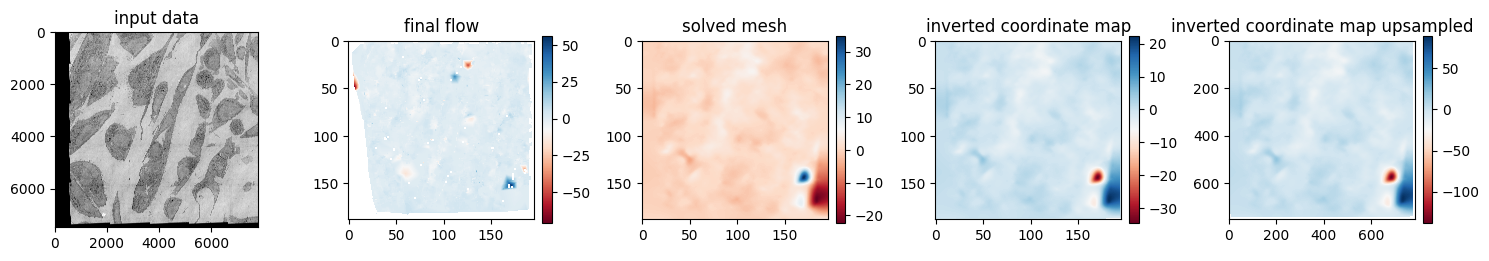

In [36]:
z_i = 1 # z index to plot

# Plot (left to right): high res. flow, upsampled low res. flow, combined flow to use for alignment.
f, ax = plt.subplots(1, 5, figsize=(15, 3))

cax1 = ax[0].imshow(data_full[:, :, z_i, 0].T, cmap=plt.cm.Greys_r)
ax[0].set_title("input data")

cax2 = ax[1].imshow(final_flow[0, z_i, ...], cmap=plt.cm.RdBu)
ax[1].set_title("final flow")

cax3 = ax[2].imshow(solved[0, z_i, ...], cmap=plt.cm.RdBu)
ax[2].set_title("solved mesh")

cax4 = ax[3].imshow(inv_map[0, z_i, ...], cmap=plt.cm.RdBu)
ax[3].set_title("inverted coordinate map")

cax5 = ax[4].imshow(inv_map_full[0, z_i, ...], cmap=plt.cm.RdBu)
ax[4].set_title("inverted coordinate map upsampled")

# cbar1 = f.colorbar(cax1, fraction=0.046, pad=0.04)
cbar2 = f.colorbar(cax2, fraction=0.046, pad=0.04)
cbar3 = f.colorbar(cax3, fraction=0.046, pad=0.04)
cbar4 = f.colorbar(cax4, fraction=0.046, pad=0.04)
cbar5 = f.colorbar(cax5, fraction=0.046, pad=0.04)
f.tight_layout()


We are now ready to render the aligned volume

In a distributed environment, this can be done with the `WarpByMap` processor.

In [37]:
data_2_warp.shape

(31232, 29952, 3, 1)

Cropping of volume (necessary check to prevent implementation limit in warping routine)

In [40]:
## Todo 
# Fix limitation by warping in chunks
data_2_warp_cropped = data_2_warp[:32766, :32766, :, :]
data_2_warp_cropped.shape

(31232, 29952, 3, 1)

In [41]:
warped = [np.transpose(data_2_warp_cropped[:, :, 0:1, 0], [2, 1, 0])]

for z in tqdm(range(1, data_2_warp_cropped.shape[2])):
  data_box = bounding_box.BoundingBox(start=(0, 0, 0), size=(data_2_warp_cropped.shape[0], data_2_warp_cropped.shape[1], 1))
  out_box = bounding_box.BoundingBox(start=(0, 0, 0), size=(data_2_warp_cropped.shape[0], data_2_warp_cropped.shape[1], 1))

  data = np.transpose(data_2_warp_cropped[data_box.start[0]:data_box.end[0],
                                          data_box.start[1]:data_box.end[1],
                                          z:z+1, 0:1], [3, 2, 1, 0])
  warped.append(
      warp.warp_subvolume(data, data_box, inv_map_full[:, z:z+1, ...], box_high, stride, out_box, 'lanczos', parallelism=1)[0, ...])

  0%|          | 0/2 [00:00<?, ?it/s]

In [43]:
warped_xyz = np.transpose(np.concatenate(warped, axis=0), [2, 1, 0])
warped_xyz.shape

(31232, 29952, 3)

Render an XZ cross section to check the quality of the alignment visually.  
This is not so informative since there is only 3 z-levels

Text(0.5, 1.0, 'Aligned')

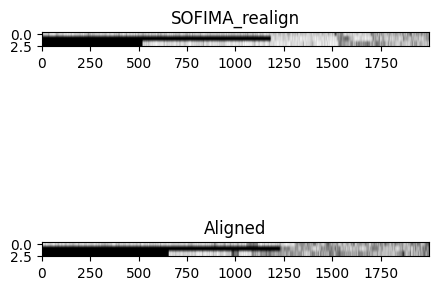

In [44]:
unwarped = data_2_warp[1000:3000, 1000:3000, :, 0] # x, y, z

f, ax = plt.subplots(2, 1, figsize=(5, 5))
ax[0].imshow(warped_xyz[1000:3000, 500, :].T, cmap=plt.cm.Greys_r, aspect=100/4, vmin=0, vmax=255) # Adjust aspect ratio based on voxel dimension (e.g. 100nm (z) / 4 nm (x))
ax[0].set_title('SOFIMA_realign')
ax[1].imshow(unwarped[:, 500, :].T, cmap=plt.cm.Greys_r, aspect=100/4, vmin=0, vmax=255)
ax[1].set_title('Aligned')

# 6. Export to WebKnossos
Write result to remote WebKnossos dataset (requires authentication token)

In [45]:
from tempfile import TemporaryDirectory

In [48]:
new_dataset_name = dataset_name + "_SOFIMA_realigned"
new_url = f"{url}/datasets/{organization_id}/{new_dataset_name}"
token='test1234' # This will ultimately fail since this is a placeholder token

# Name check
print(f"New dataset name: {new_dataset_name}")

New dataset name: 20231107_MCF7_UAC_test_SOFIMA_realigned


In [49]:
with wk.webknossos_context(
    url=url,
    token=token,
):
    with TemporaryDirectory() as tempdir:
        new_dataset = wk.Dataset(
            dataset_path=tempdir,
            name=new_dataset_name,
            voxel_size=dataset.voxel_size
        )
        warped_layer = new_dataset.add_layer(
            "realigned_SOFIMA",
            wk.COLOR_CATEGORY,
            dtype_per_layer="uint8",
            compressed=True
            )
        warped_layer.bounding_box = bbox_cropped.align_with_mag(himag) # Highest MAG
        warped_layer.add_mag(himag, compress=True).write(warped_xyz)
        warped_layer.downsample(sampling_mode="constant_z")

        remote_ds = new_dataset.upload(
            layers_to_link=[dataset.layers[layer]]
        )

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()